In [1]:
import numpy as np
import time, os, sys
from glob import glob
from tifffile import imread
from tqdm import tqdm
import pandas as pd
import pickle
from multiprocessing import cpu_count
ncpu = cpu_count()

# from urllib.parse import urlparse
# import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
# mpl.rcParams['figure.dpi'] = 96
%config InlineBackend.figure_format = 'retina'

from cellpose import utils, models, transforms, dynamics, plot

import mxnet as mx
from mxnet import init, nd

%load_ext autoreload
%autoreload 2

%config IPCompleter.greedy=True

In [2]:
def plot_nd(arr, figsize=(15,15)):
    nd = len(arr)
    fig, axes = plt.subplots(ncols=nd, figsize=figsize)
    for img, ax in zip(arr, axes.flatten()):
        if img.ndim >2:
            img = np.squeeze(img)
        ax.imshow(img, cmap='gray')
    plt.show()

## Load dsb dataset

In [3]:
# HOME = '/home/lis-paul'
HOME = '/home/qzt'
PATH = "data/dsb2018/dsb2018_sub1/"
# PATH = "data/centuri/train/"
# path = os.path.join(HOME, "data/dsb2018/dsb2018_sub1/images/*.tif")
pathX = os.path.join(HOME, PATH+"images/*.tif")
pathY = os.path.join(HOME, PATH+"masks/*.tif")
X_file = sorted(glob(pathX))
Y_file = sorted(glob(pathY))
print(len(X_file), len(Y_file))

X = list(map(imread,X_file))
Y = list(map(imread,Y_file))
# n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]


292 292


In [4]:
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]

## manual assign train/val index for debugging
# ind_train = [1,2,3,4]
# ind_val = [0]

X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 292
- training:       248
- validation:      44


In [5]:
for x, y in zip(X_val, Y_val):
    assert(x.shape == y.shape)

## transform mask to flow representation

In [9]:
%%time
flow_trn2, diam_trn2 = dynamics.labels_to_flows2(Y_trn)
flow_val2, diam_val2 = dynamics.labels_to_flows2(Y_val)

NOTE: computing flows for labels (could be done before to save time)



NOTE: computing flows for labels (could be done before to save time)



CPU times: user 18.2 s, sys: 111 ms, total: 18.3 s
Wall time: 18.3 s


In [7]:
%%time
flow_trn = dynamics.labels_to_flows(Y_trn)
flow_val = dynamics.labels_to_flows(Y_val)

NOTE: computing flows for labels (could be done before to save time)



NOTE: computing flows for labels (could be done before to save time)



CPU times: user 31.8 s, sys: 478 ms, total: 32.3 s
Wall time: 32.2 s


In [10]:
with open('flow_trn2.pickle', 'wb') as handle:
    pickle.dump(flow_trn2, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('flow_val2.pickle', 'wb') as handle:
    pickle.dump(flow_val2, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
with open('flow_trn2.pickle', 'rb') as handle:
    flow_trn2 = pickle.load(handle)
with open('flow_val2.pickle', 'rb') as handle:
    flow_val2 = pickle.load(handle)

## Test the original transforms.random_rotate_and_resize function

In [15]:
train_data, test_data, run_test = transforms.reshape_data(X_trn, test_data=X_val, channels=[0,0])

In [17]:
train_data[0].shape, test_data[0].shape

((2, 520, 696), (2, 256, 256))

In [62]:
imgi, lbl, scale = transforms.random_rotate_and_resize(train_data[:4], Y=flow_trn2[:4], rescale=np.ones(4),
                                                        scale_range=1, xy=(256,256))


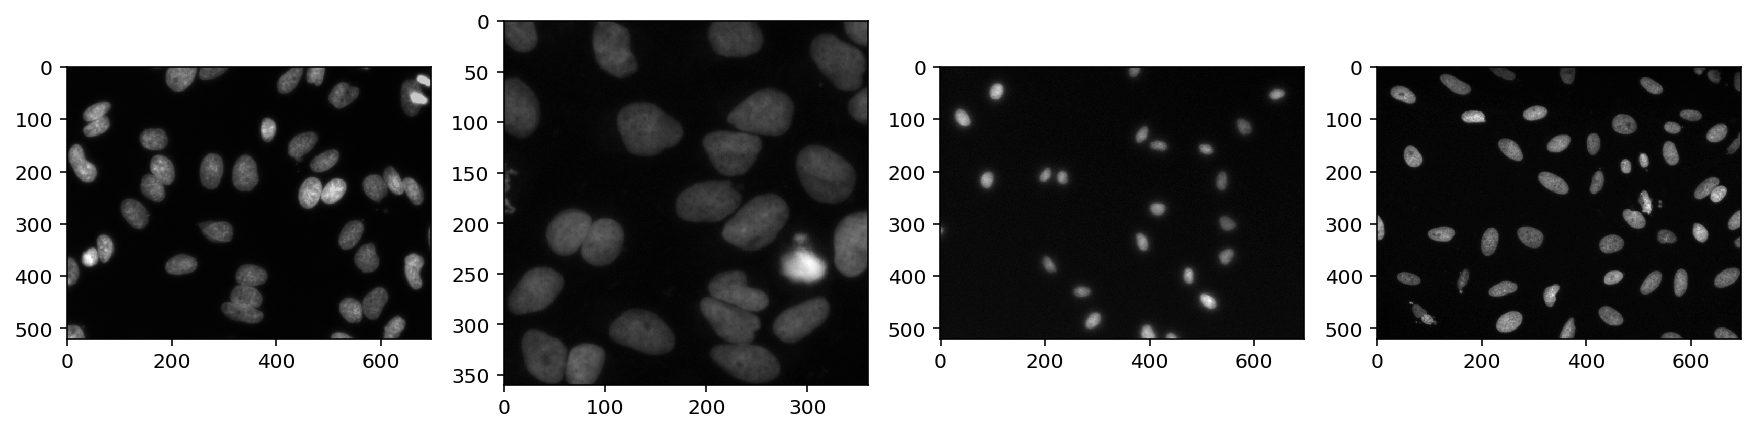

In [63]:
plot_nd(X_trn[:4])

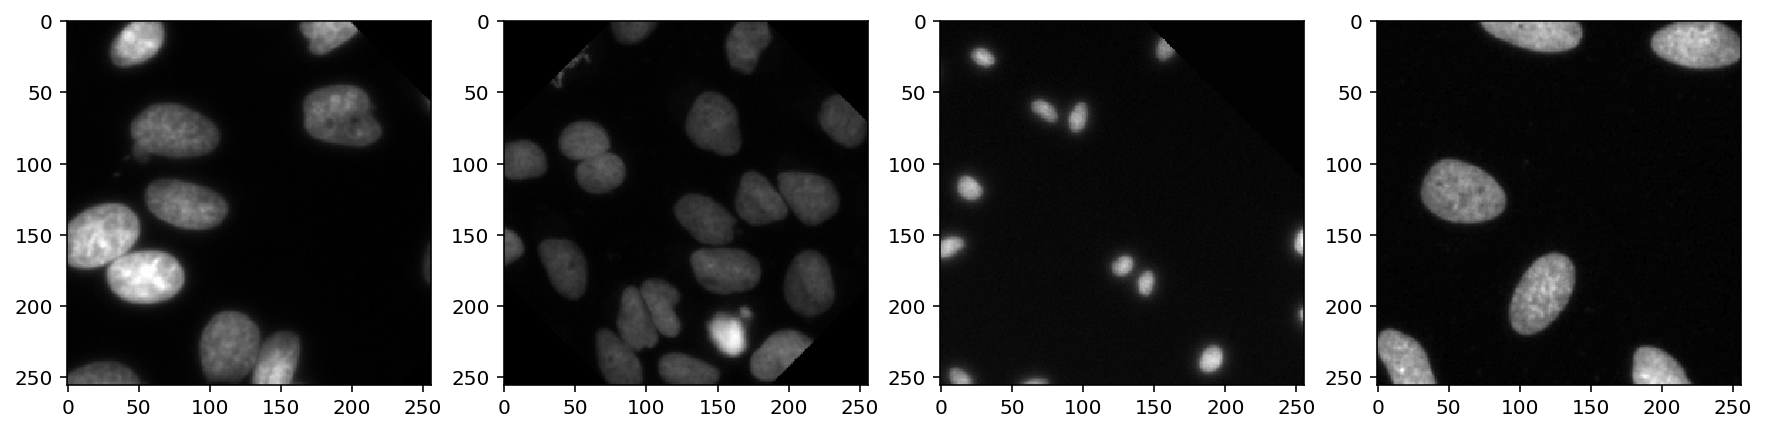

In [64]:
plot_nd([x[0,...] for x in imgi[:4]])

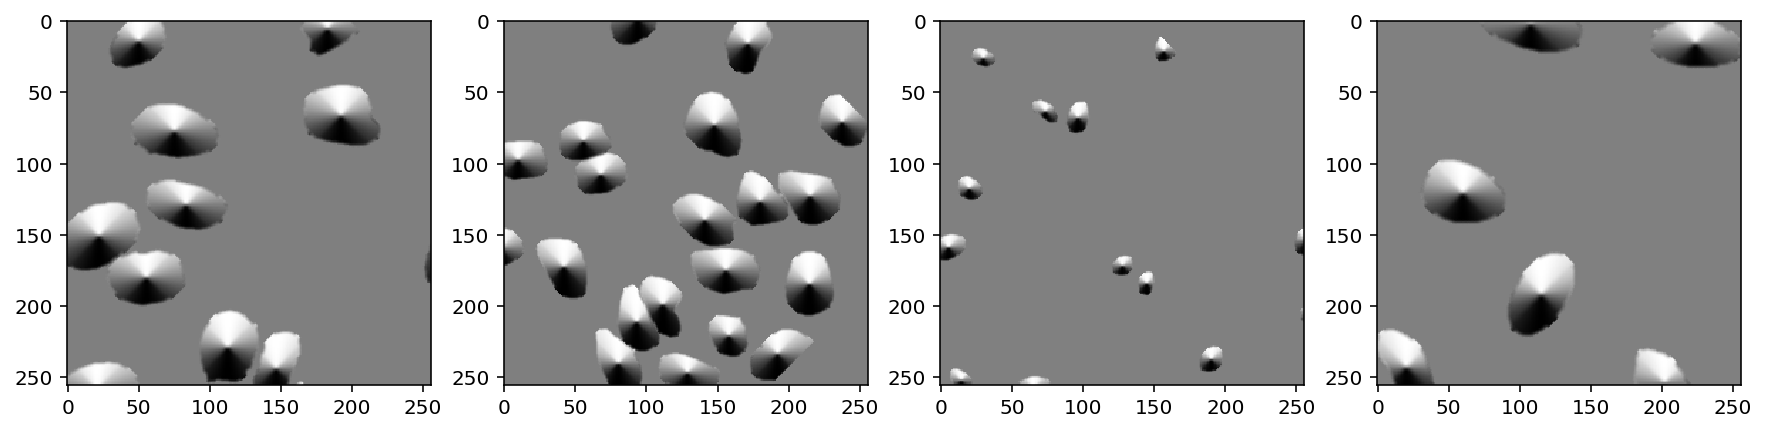

In [65]:
plot_nd([x[1,...] for x in lbl[:4]])

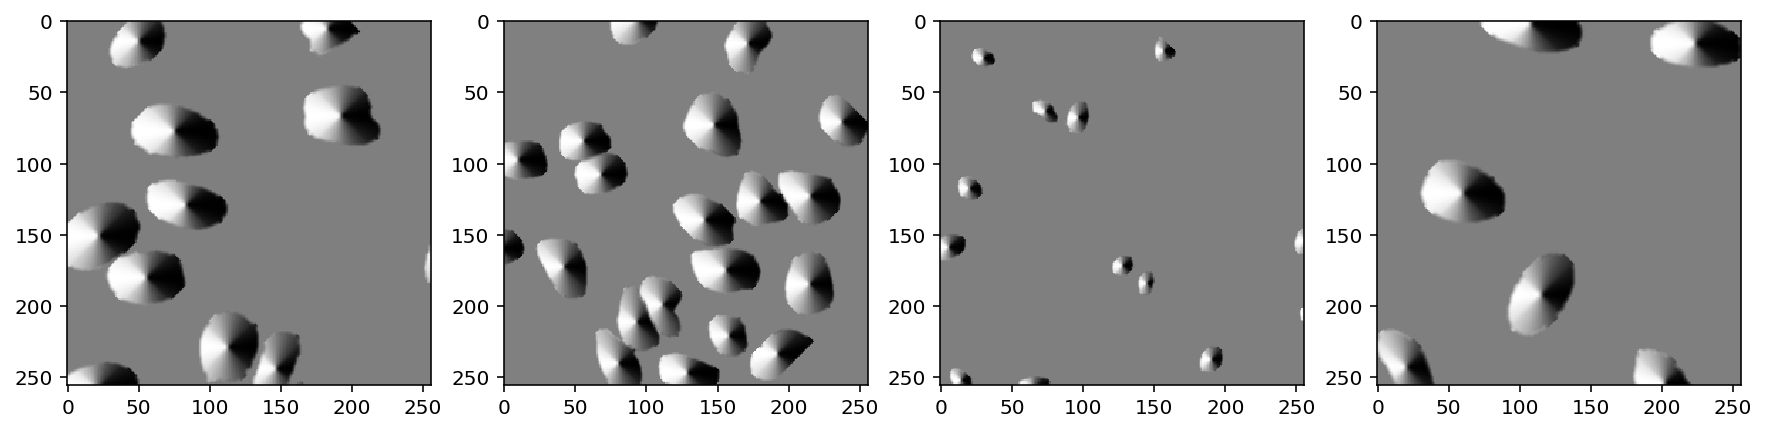

In [66]:
plot_nd([x[2,...] for x in lbl[:4]])

## Try the mxnet's dataset and augmentation function

In [27]:
ranf=list(np.random.ranf(8)+10*np.random.ranf(1));ranf

[7.346865635837803,
 7.208599527281888,
 7.73518670264748,
 7.2997315712223605,
 7.5569275857153295,
 7.431550248415071,
 8.0015567949614,
 7.619380580280345]

In [28]:
from albumentations import *
import cv2
# from mxnet.gluon.data.vision.transforms import Normalize

def transform_aug(image, label):

    def normalize99(img):
    """ normalize image so 0.0 is 1st percentile and 1.0 is 99th percentile """
    X = img.copy()
    X = (X - np.percentile(X, 1)) / (np.percentile(X, 99) - np.percentile(X, 1))
    return X
    
    
    ranf=list(np.random.ranf(8)+10*np.random.ranf(1))
    AUG = Compose([
        CoarseDropout(max_holes=64, max_height=8, max_width=8, min_holes=None, min_height=None, min_width=None, 
                  fill_value=ranf, always_apply=False, p=.9),
        GaussNoise(var_limit=(0.0, 0.05), mean=0, p=.5),
        GaussianBlur(blur_limit=3, p=.5),
        Flip(p=0.5),
        ShiftScaleRotate(shift_limit=0, scale_limit=(0.2, 1), rotate_limit=15, 
                         interpolation=0, border_mode=cv2.BORDER_REFLECT_101, value=0, mask_value=0, p=.9),
        ElasticTransform(alpha=100, sigma=10, alpha_affine=1, p=0.7, 
                         interpolation=0, border_mode=cv2.BORDER_REFLECT_101, value=0, mask_value=0),
        RandomCrop(256, 256, always_apply=True, p=1.0)
    ], p=0.9)
    
    data = {"image": image, "mask": label}
    augmented = AUG(**data)
        
    flow, _ = dynamics.masks_to_flows2(augmented["mask"])

    image = nd.array(augmented["image"])
    prob  = nd.array(augmented["mask"]>0)
    flowy = nd.array(flow[0,...])
    flowx = nd.array(flow[1,...])
    
    return image, prob, flowy, flowx

def transform_crop(image, label):

    AUG = RandomCrop(256, 256, always_apply=True, p=1.0)

    data = {"image": image, "mask": label}
    augmented = AUG(**data)

    flow, _ = dynamics.masks_to_flows2(augmented["mask"])

    image = nd.array(augmented["image"])
    prob  = nd.array(augmented["mask"]>0)
    flowy = nd.array(flow[0,...])
    flowx = nd.array(flow[1,...])
    
    return image, prob, flowy, flowx

In [25]:
X_trn[0].dtype

dtype('uint8')

In [29]:
# X = [mx.nd.array(x[...,np.newaxis]) for x in X_trn[:16]]
dataset_trn = mx.gluon.data.ArrayDataset(X_trn,Y_trn)
trn_loader = mx.gluon.data.DataLoader(dataset_trn.transform(transform_aug), batch_size=8, num_workers=ncpu)
dataset_val = mx.gluon.data.ArrayDataset(X_val,Y_val)
val_loader = mx.gluon.data.DataLoader(dataset_val.transform(transform_crop), batch_size=8, num_workers=ncpu)

/home/qzt/miniconda3/envs/cellpose/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/qzt/miniconda3/envs/cellpose/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
for img, prob, flowy, flowx in trn_loader:
#     print(img.shape, prob.shape, flowy.shape, flowx.shape)
    plot_nd(img.asnumpy())
    plot_nd(prob.asnumpy())
    plot_nd(flowy.asnumpy())
    plot_nd(flowx.asnumpy())

In [59]:
args[0].shape

(520, 696, 1)

In [136]:
for X_batch, y_batch in data_loader:
    print("X_batch has shape {}, and y_batch has shape {}".format(X_batch.shape, y_batch.shape))

X_batch has shape (8, 3), and y_batch has shape (8, 1)
X_batch has shape (2, 3), and y_batch has shape (2, 1)


In [69]:
y.shape

(3, 520, 696)

In [81]:
y1,y2,y3 = np.squeeze(np.split(y, 3, axis=0))

In [82]:
y1.shape

(520, 696)

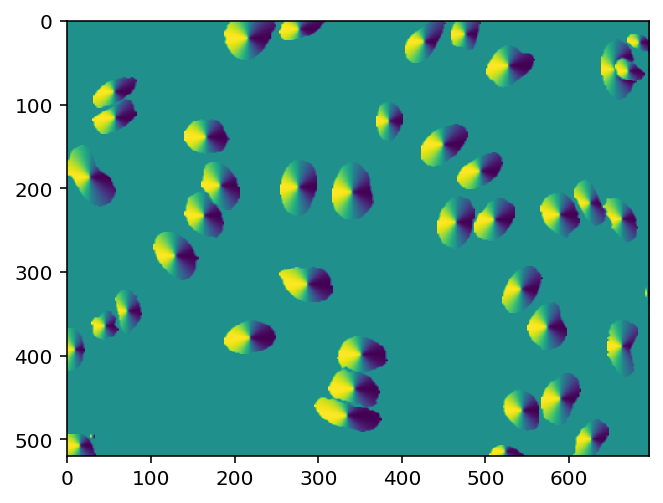

In [85]:
plt.imshow(y3)